In [41]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [42]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [43]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    # print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [44]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        # print(x[:,0].mean(),np.median(x[:,0]),x[:,0].max(),x[:,0].min(),x.shape)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)
        print(np.unique(y))
        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [45]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [46]:
device = mps_device

In [47]:
x.type()

'torch.mps.FloatTensor'

In [48]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('/Users/jandh/Downloads/data (1)/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [49]:
sys.getsizeof(dec_data)/1000000

303.662128

In [50]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [51]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1290, 0.0188, 0.1288,  ..., 0.3265, 0.1279, 0.0115],
          [0.1290, 0.0138, 0.1288,  ..., 0.3265, 0.1279, 0.0115],
          [0.1290, 0.0138, 0.1288,  ..., 0.3265, 0.1279, 0.0115],
          ...,
          [0.1287, 0.0035, 0.1286,  ..., 0.0487, 0.1277, 0.0415],
          [0.1287, 0.0035, 0.1286,  ..., 0.0487, 0.1277, 0.0415],
          [0.1288, 0.0128, 0.1286,  ..., 0.0030, 0.1277, 0.0415]]]],
       dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [12]:
# #CPU version
# class deeplob(nn.Module):
#     def __init__(self, y_len):
#         super().__init__()
#         self.y_len = y_len
        
#         # convolution blocks
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
#             nn.LeakyReLU(negative_slope=0.01),
# #             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#         )
        
#         # inception moduels
#         self.inp1 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
#         self.inp2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
#         self.inp3 = nn.Sequential(
#             nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
        
#         # lstm layers
#         self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
#         self.fc1 = nn.Linear(64, self.y_len)

#     def forward(self, x):
#         # h0: (number of hidden layers, batch size, hidden size)
#         h0 = torch.zeros(1, x.size(0), 64).to(device)
#         c0 = torch.zeros(1, x.size(0), 64).to(device)
    
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x_inp1 = self.inp1(x)
#         x_inp2 = self.inp2(x)
#         x_inp3 = self.inp3(x)  
        
#         x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
# #         x = torch.transpose(x, 1, 2)
#         x = x.permute(0, 2, 1, 3)
#         x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
#         x, _ = self.lstm(x, (h0, c0))
#         x = x[:, -1, :]
#         x = self.fc1(x)
#         forecast_y = torch.softmax(x, dim=1)
        
#         return forecast_y

In [8]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [14]:
# # testing gradiant flows for CPU and GPU

# model = deeplob(y_len = dataset_train.num_classes)
# model2 = deeplob(y_len = dataset_train.num_classes)
# model2.load_state_dict(model.state_dict())
# # print(torch.allclose(model.weight, model2.weight))

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

# data_iter = iter(train_loader)
# inputs , targets = next(data_iter)
# device = 'cpu'
# # print(inputs)
#  # = train_loader.next()
# optimizer.zero_grad()
# outputs = model(inputs.to(torch.float))
# loss = criterion(outputs, targets.to(dtype=torch.int64))
# print(loss)
# loss.backward()
# optimizer.step()

# print(model.inp3[1].weight.grad.max())

# for name, param in model.lstm.named_parameters():
#     if 'weight' in name:
#         print(name, param.grad.max()) 

# for name, param in model2.lstm.named_parameters():
#     if 'weight' in name:
#         print(name, param.grad.max()) 

# print(model2.inp3[1].weight.grad.max())

# device = mps_device
# model2.to(mps_device)
# # inputs , targets = next(data_iter)
# optimizer2.zero_grad()
# outputs2 = model2(inputs.to(mps_device,dtype = torch.float32))
# loss2 = criterion(outputs2, targets.to(mps_device,dtype=torch.int64))
# print(loss2)
# loss2.backward()
# optimizer2.step()

# def compare_models(model_1, model_2):
#     models_differ = 0
#     for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
#         if torch.equal(key_item_1[1], key_item_2[1]):
#             pass
#         else:
#             models_differ += 1
#             if (key_item_1[0] == key_item_2[0]):
#                 print('Mismtach found at', key_item_1[0])
#             else:
#                 raise Exception
#     if models_differ == 0:
#         print('Models match perfectly! :)')

In [13]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
device = mps_device

NameError: name 'deeplob' is not defined

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
state_dict = None

In [17]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    global state_dict
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            # state_dict = copy.deepcopy(model.state_dict())
            torch.save(model, '/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [18]:
# import multiprocessing
# multiprocessing.set_start_method("fork")

In [19]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▊                                        | 1/50 [02:21<1:55:42, 141.69s/it]

model saved
0:02:21.690984
Epoch 1/50, Train Loss: 0.9275,           Validation Loss: 1.0078, Duration: 0:02:21.690984, Best Val Epoch: 0


  4%|█▋                                       | 2/50 [05:48<2:23:46, 179.73s/it]

model saved
0:03:26.351710
Epoch 2/50, Train Loss: 0.8316,           Validation Loss: 0.9673, Duration: 0:03:26.351710, Best Val Epoch: 1


  6%|██▍                                      | 3/50 [09:06<2:27:30, 188.30s/it]

model saved
0:03:18.499747
Epoch 3/50, Train Loss: 0.7994,           Validation Loss: 0.9436, Duration: 0:03:18.499747, Best Val Epoch: 2


  8%|███▎                                     | 4/50 [12:34<2:30:22, 196.14s/it]

model saved
0:03:28.155455
Epoch 4/50, Train Loss: 0.7811,           Validation Loss: 0.9283, Duration: 0:03:28.155455, Best Val Epoch: 3


 10%|████                                     | 5/50 [16:23<2:36:03, 208.08s/it]

model saved
0:03:49.241294
Epoch 5/50, Train Loss: 0.7686,           Validation Loss: 0.9175, Duration: 0:03:49.241294, Best Val Epoch: 4


 12%|████▉                                    | 6/50 [20:18<2:39:06, 216.98s/it]

model saved
0:03:54.247768
Epoch 6/50, Train Loss: 0.7583,           Validation Loss: 0.9132, Duration: 0:03:54.247768, Best Val Epoch: 5


 14%|█████▋                                   | 7/50 [40:04<6:22:41, 534.00s/it]

model saved
0:19:46.685416
Epoch 7/50, Train Loss: 0.7496,           Validation Loss: 0.9059, Duration: 0:19:46.685416, Best Val Epoch: 6


 16%|██████                                | 8/50 [1:12:53<11:33:32, 990.78s/it]

0:32:48.827425
Epoch 8/50, Train Loss: 0.7418,           Validation Loss: 0.9068, Duration: 0:32:48.827425, Best Val Epoch: 6


 18%|██████▋                              | 9/50 [1:30:58<11:37:04, 1020.11s/it]

0:18:04.607208
Epoch 9/50, Train Loss: 0.7347,           Validation Loss: 0.9122, Duration: 0:18:04.607208, Best Val Epoch: 6


 20%|███████▏                            | 10/50 [1:49:31<11:39:09, 1048.75s/it]

0:18:32.868695
Epoch 10/50, Train Loss: 0.7289,           Validation Loss: 0.9122, Duration: 0:18:32.868695, Best Val Epoch: 6


 22%|███████▉                            | 11/50 [2:27:58<15:32:03, 1433.94s/it]

0:38:27.345521
Epoch 11/50, Train Loss: 0.7229,           Validation Loss: 0.9071, Duration: 0:38:27.345521, Best Val Epoch: 6


 24%|████████▋                           | 12/50 [3:03:24<17:21:31, 1644.50s/it]

model saved
0:35:26.096480
Epoch 12/50, Train Loss: 0.7187,           Validation Loss: 0.9055, Duration: 0:35:26.096480, Best Val Epoch: 11


 26%|█████████▎                          | 13/50 [3:12:00<13:23:20, 1302.71s/it]

0:08:36.231804
Epoch 13/50, Train Loss: 0.7140,           Validation Loss: 0.9141, Duration: 0:08:36.231804, Best Val Epoch: 11


 28%|██████████                          | 14/50 [3:45:10<15:06:01, 1510.05s/it]

0:33:09.144797
Epoch 14/50, Train Loss: 0.7096,           Validation Loss: 0.9064, Duration: 0:33:09.144797, Best Val Epoch: 11


 30%|██████████▊                         | 15/50 [4:11:33<14:53:51, 1532.33s/it]

0:26:23.959671
Epoch 15/50, Train Loss: 0.7057,           Validation Loss: 0.9107, Duration: 0:26:23.959671, Best Val Epoch: 11


 32%|███████████▌                        | 16/50 [4:46:54<16:08:38, 1709.37s/it]

0:35:20.508877
Epoch 16/50, Train Loss: 0.7026,           Validation Loss: 0.9111, Duration: 0:35:20.508877, Best Val Epoch: 11


 34%|████████████▏                       | 17/50 [5:05:38<14:03:22, 1533.42s/it]

0:18:44.244464
Epoch 17/50, Train Loss: 0.6991,           Validation Loss: 0.9199, Duration: 0:18:44.244464, Best Val Epoch: 11


 36%|████████████▉                       | 18/50 [5:30:22<13:29:51, 1518.49s/it]

0:24:43.722550
Epoch 18/50, Train Loss: 0.6960,           Validation Loss: 0.9121, Duration: 0:24:43.722550, Best Val Epoch: 11


 38%|█████████████▋                      | 19/50 [6:30:12<18:26:02, 2140.72s/it]

0:59:50.232588
Epoch 19/50, Train Loss: 0.6941,           Validation Loss: 0.9104, Duration: 0:59:50.232588, Best Val Epoch: 11


 40%|██████████████▍                     | 20/50 [7:15:04<19:13:02, 2306.09s/it]

0:44:51.521763
Epoch 20/50, Train Loss: 0.6906,           Validation Loss: 0.9104, Duration: 0:44:51.521763, Best Val Epoch: 11


 42%|███████████████                     | 21/50 [7:49:34<18:00:21, 2235.23s/it]

0:34:30.006216
Epoch 21/50, Train Loss: 0.6891,           Validation Loss: 0.9209, Duration: 0:34:30.006216, Best Val Epoch: 11


 44%|███████████████▊                    | 22/50 [8:15:59<15:52:02, 2040.09s/it]

0:26:25.024193
Epoch 22/50, Train Loss: 0.6869,           Validation Loss: 0.9125, Duration: 0:26:25.024193, Best Val Epoch: 11


 46%|████████████████▌                   | 23/50 [8:47:52<15:00:52, 2001.95s/it]

0:31:53.003818
Epoch 23/50, Train Loss: 0.6844,           Validation Loss: 0.9143, Duration: 0:31:53.003818, Best Val Epoch: 11


 48%|█████████████████▎                  | 24/50 [8:49:51<10:22:43, 1437.05s/it]

0:01:59.305633
Epoch 24/50, Train Loss: 0.6828,           Validation Loss: 0.9162, Duration: 0:01:59.305633, Best Val Epoch: 11


 50%|██████████████████▌                  | 25/50 [8:52:19<7:17:37, 1050.29s/it]

0:02:28.008038
Epoch 25/50, Train Loss: 0.6802,           Validation Loss: 0.9272, Duration: 0:02:28.008038, Best Val Epoch: 11


 52%|███████████████████▊                  | 26/50 [8:55:21<5:15:53, 789.74s/it]

0:03:01.884429
Epoch 26/50, Train Loss: 0.6790,           Validation Loss: 0.9168, Duration: 0:03:01.884429, Best Val Epoch: 11


 54%|████████████████████▌                 | 27/50 [8:58:31<3:53:48, 609.93s/it]

0:03:10.389775
Epoch 27/50, Train Loss: 0.6775,           Validation Loss: 0.9250, Duration: 0:03:10.389775, Best Val Epoch: 11


 56%|█████████████████████▎                | 28/50 [9:01:39<2:57:10, 483.19s/it]

0:03:07.506017
Epoch 28/50, Train Loss: 0.6756,           Validation Loss: 0.9178, Duration: 0:03:07.506017, Best Val Epoch: 11


 58%|██████████████████████                | 29/50 [9:04:50<2:18:27, 395.61s/it]

0:03:11.268407
Epoch 29/50, Train Loss: 0.6732,           Validation Loss: 0.9183, Duration: 0:03:11.268407, Best Val Epoch: 11


 60%|██████████████████████▊               | 30/50 [9:08:05<1:51:45, 335.30s/it]

0:03:14.553216
Epoch 30/50, Train Loss: 0.6722,           Validation Loss: 0.9198, Duration: 0:03:14.553216, Best Val Epoch: 11


 62%|███████████████████████▌              | 31/50 [9:11:35<1:34:19, 297.88s/it]

0:03:30.587206
Epoch 31/50, Train Loss: 0.6712,           Validation Loss: 0.9214, Duration: 0:03:30.587206, Best Val Epoch: 11


 64%|████████████████████████▎             | 32/50 [9:15:13<1:22:07, 273.75s/it]

0:03:37.422006
Epoch 32/50, Train Loss: 0.6701,           Validation Loss: 0.9238, Duration: 0:03:37.422006, Best Val Epoch: 11


 66%|█████████████████████████             | 33/50 [9:18:48<1:12:38, 256.35s/it]

0:03:35.770502
Epoch 33/50, Train Loss: 0.6680,           Validation Loss: 0.9206, Duration: 0:03:35.770502, Best Val Epoch: 11


 68%|█████████████████████████▊            | 34/50 [9:22:09<1:03:55, 239.71s/it]

0:03:20.864819
Epoch 34/50, Train Loss: 0.6666,           Validation Loss: 0.9162, Duration: 0:03:20.864819, Best Val Epoch: 11


 70%|████████████████████████████            | 35/50 [9:25:29<56:53, 227.58s/it]

0:03:19.289088
Epoch 35/50, Train Loss: 0.6667,           Validation Loss: 0.9201, Duration: 0:03:19.289088, Best Val Epoch: 11


 72%|████████████████████████████▊           | 36/50 [9:28:50<51:15, 219.69s/it]

0:03:21.274789
Epoch 36/50, Train Loss: 0.6647,           Validation Loss: 0.9210, Duration: 0:03:21.274789, Best Val Epoch: 11


 74%|█████████████████████████████▌          | 37/50 [9:32:11<46:21, 213.98s/it]

0:03:20.637919
Epoch 37/50, Train Loss: 0.6638,           Validation Loss: 0.9209, Duration: 0:03:20.637919, Best Val Epoch: 11


 76%|██████████████████████████████▍         | 38/50 [9:35:32<42:03, 210.29s/it]

0:03:21.690577
Epoch 38/50, Train Loss: 0.6622,           Validation Loss: 0.9222, Duration: 0:03:21.690577, Best Val Epoch: 11


 78%|███████████████████████████████▏        | 39/50 [9:38:58<38:19, 209.07s/it]

0:03:26.232447
Epoch 39/50, Train Loss: 0.6613,           Validation Loss: 0.9258, Duration: 0:03:26.232447, Best Val Epoch: 11


 80%|████████████████████████████████        | 40/50 [9:42:21<34:32, 207.25s/it]

0:03:22.986045
Epoch 40/50, Train Loss: 0.6604,           Validation Loss: 0.9231, Duration: 0:03:22.986045, Best Val Epoch: 11


 82%|████████████████████████████████▊       | 41/50 [9:45:44<30:51, 205.72s/it]

0:03:22.156574
Epoch 41/50, Train Loss: 0.6597,           Validation Loss: 0.9179, Duration: 0:03:22.156574, Best Val Epoch: 11


 84%|█████████████████████████████████▌      | 42/50 [9:49:06<27:16, 204.62s/it]

0:03:22.050831
Epoch 42/50, Train Loss: 0.6588,           Validation Loss: 0.9250, Duration: 0:03:22.050831, Best Val Epoch: 11


 86%|██████████████████████████████████▍     | 43/50 [9:52:42<24:17, 208.17s/it]

0:03:36.467662
Epoch 43/50, Train Loss: 0.6580,           Validation Loss: 0.9219, Duration: 0:03:36.467662, Best Val Epoch: 11


 88%|███████████████████████████████████▏    | 44/50 [9:56:23<21:11, 211.95s/it]

0:03:40.767641
Epoch 44/50, Train Loss: 0.6571,           Validation Loss: 0.9242, Duration: 0:03:40.767641, Best Val Epoch: 11


 90%|████████████████████████████████████    | 45/50 [9:59:46<17:26, 209.27s/it]

0:03:22.999976
Epoch 45/50, Train Loss: 0.6567,           Validation Loss: 0.9223, Duration: 0:03:22.999976, Best Val Epoch: 11


 92%|███████████████████████████████████▉   | 46/50 [10:03:10<13:50, 207.67s/it]

0:03:23.955101
Epoch 46/50, Train Loss: 0.6551,           Validation Loss: 0.9237, Duration: 0:03:23.955101, Best Val Epoch: 11


 94%|████████████████████████████████████▋  | 47/50 [10:06:42<10:26, 208.98s/it]

0:03:32.014281
Epoch 47/50, Train Loss: 0.6550,           Validation Loss: 0.9248, Duration: 0:03:32.014281, Best Val Epoch: 11


 96%|█████████████████████████████████████▍ | 48/50 [10:10:26<07:07, 213.62s/it]

0:03:44.443801
Epoch 48/50, Train Loss: 0.6542,           Validation Loss: 0.9283, Duration: 0:03:44.443801, Best Val Epoch: 11


 98%|██████████████████████████████████████▏| 49/50 [10:14:11<03:36, 216.99s/it]

0:03:44.861794
Epoch 49/50, Train Loss: 0.6531,           Validation Loss: 0.9215, Duration: 0:03:44.861794, Best Val Epoch: 11


100%|███████████████████████████████████████| 50/50 [10:17:36<00:00, 741.12s/it]

0:03:24.524774
Epoch 50/50, Train Loss: 0.6529,           Validation Loss: 0.9236, Duration: 0:03:24.524774, Best Val Epoch: 11


In [20]:
print(train_losses)

[0.92754553 0.83157098 0.7994026  0.78108138 0.76856464 0.75826246
 0.74962036 0.74180985 0.734716   0.72889079 0.72285855 0.71870746
 0.71396509 0.7096324  0.70574385 0.70256218 0.69905267 0.6959799
 0.69410729 0.69056099 0.68910624 0.68687898 0.68443133 0.68280796
 0.68018579 0.67900137 0.6775481  0.67562845 0.673156   0.67218286
 0.67122931 0.67007577 0.66795675 0.66663803 0.66665017 0.66470385
 0.66379603 0.66222505 0.66133476 0.66040887 0.65970554 0.65877602
 0.65800051 0.65706162 0.65670245 0.6550968  0.65502462 0.65418764
 0.65313373 0.65292982]


In [21]:
# import pickle
# with open('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/train_losses.pkl', 'wb') as f:
#     pickle.dump(train_losses, f)
# with open('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/val_losses.pkl', 'wb') as f:
#     pickle.dump(val_losses, f)

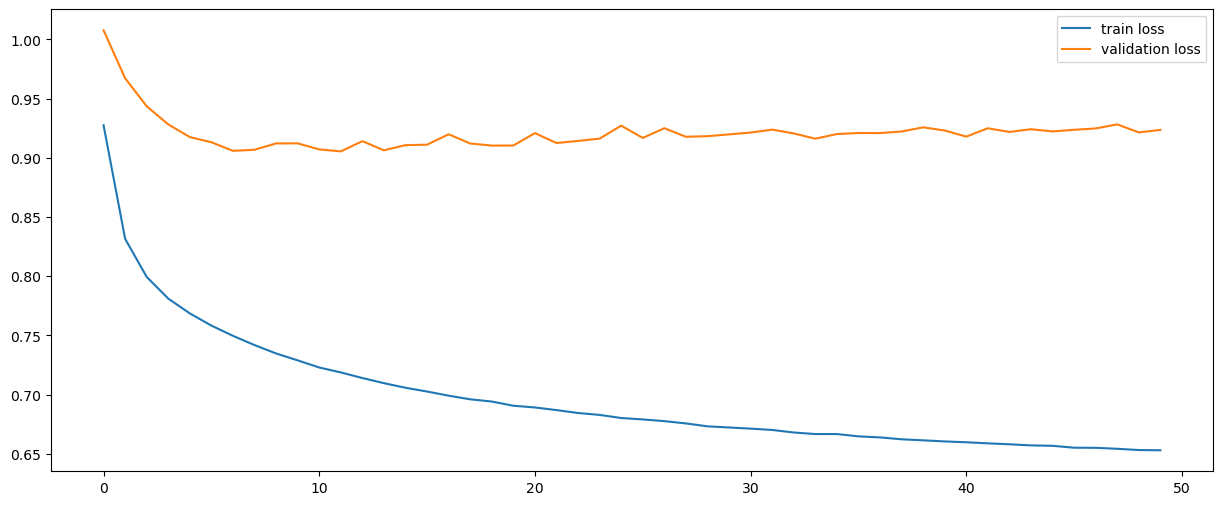

In [22]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [23]:
# model = None

## Model_Testing

In [67]:
# model = torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.7230


In [25]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

In [26]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7230012617572837
              precision    recall  f1-score   support

           0     0.6983    0.7297    0.7136     47915
           1     0.7975    0.7080    0.7501     48050
           2     0.6815    0.7322    0.7060     43523

    accuracy                         0.7230    139488
   macro avg     0.7258    0.7233    0.7232    139488
weighted avg     0.7272    0.7230    0.7238    139488



In [52]:
# model = torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_model_pytorch')